In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import calendar
import time
import timeit
start_time = dt.datetime.now()
%matplotlib inline

# Import Data

In [2]:
%%time
data = pd.read_csv('card transactions.csv', converters = {'Merchnum': lambda x: str(x)
                                                          ,'Cardnum':lambda x:str(x)})
data.shape

CPU times: total: 125 ms
Wall time: 136 ms


(96753, 18)

In [3]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,1,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,5142183973,1/1/10,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,5142131721,1/1/10,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,5142148452,1/1/10,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Cleaning

## Drop extraenous columns

In [4]:
data = data.drop(data.columns[10:], axis = 1)
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,1/1/10,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,1/1/10,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,1/1/10,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0


## Keep only Purchase Transaction Type

In [5]:
data = data[data['Transtype'] == 'P']
print(len(data))
data.head()

96398


,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
1,2,5142183973,1/1/10,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0
2,3,5142131721,1/1/10,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0
3,4,5142148452,1/1/10,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,1/1/10,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0


## Remove single large transaction outlier

In [8]:
data[data['Amount'] == data['Amount'].max()]

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
52714,52715,5142189135,7/13/10,,INTERMEXICO,NaN,NaN,P,3102045.53,0


In [9]:
data.drop(index = 52714, inplace = True, axis = 0)

## Fill in missing values

In [10]:
data.isna().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum                0
Merch description       0
Merch state          1020
Merch zip            4300
Transtype               0
Amount                  0
Fraud                   0
dtype: int64

In [11]:
# since merchnum is a string, null values will be '' or '0'
len(data[(data['Merchnum'] == '') | (data['Merchnum'] == '0')])

3251

### Fill in Merchnum

In [12]:
data['Merchnum'] = data['Merchnum'].replace({'0':np.nan})
data['Merchnum'] = data['Merchnum'].replace({'':np.nan})

In [13]:
# dict for mapping
merchdes_merchnum = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_merchnum :
        merchdes_merchnum[merchdes] = data.loc[index, 'Merchnum']

In [14]:
# fill in by mapping with Merch description
data['Merchnum'] = data['Merchnum'].fillna(data['Merch description'].map(merchdes_merchnum))

In [15]:
# assign unknown for adjustments transactions
data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [16]:
data['Merchnum'].isna().sum()

2271

In [17]:
data.loc[data.Merchnum.isna(), 'Merch description'].unique()[:20]

array(['GRAINGER #973', 'AUTOMATED OFFICE PRODU', 'ROLL CALL NEWSPAPER',
       'MONTGOMERY COLLEGE-PHONE', 'ARGENT CHEMICAL LABS', 'CHEMUNEX',
       'TEKMAR COMPANY', 'OPERON TECHNOLOGIES INC', 'PACKAGE PLACE  THE',
       'CUBIX CORPORATION', 'SIGNAL GRAPHICS PRINTING', 'GRAINGER #932',
       'SUNSET LABORATORY', 'AUTO PARTS MACHINE SHOP',
       'THE AMERICAN PHYSIOLOGICA', 'C & M OFFICE EQUIPMENT',
       'HACH COMPANY', 'MOLECULAR PROBES INC.', 'OSU BOOKSTORES INC',
       'LEGASYS INTERNATIONAL INC'], dtype=object)

In [18]:
data.loc[data['Merchnum'].isna(), 'Merch description'].nunique()

663

2271 null merchnums with 663 unique descriptions

#### Create new Merchnums using the description field

In [19]:
# each new unique merchnum will be max(merchnum) + 1
merchnum_create = {}
max_merchnum = pd.to_numeric(data['Merchnum'], errors = 'coerce').max()
for merch_desc in data.loc[data['Merchnum'].isna(), 'Merch description'].unique():
    merchnum_create[merch_desc] = str(int(max_merchnum + 1))
    max_merchnum += 1

In [20]:
# fill in by mapping the newly created merchnums with Merch description 
data['Merchnum'] = data['Merchnum'].fillna(data['Merch description'].map(merchnum_create))

In [21]:
data['Merchnum'].isna().sum()

0

### Fill in Merch state

In [22]:
# dict for mapping
zip_state = {}
for index, zip5 in data[data['Merch zip'].notnull()]['Merch zip'].items():
    if zip5 not in zip_state:
        zip_state[zip5] = data.loc[index, 'Merch state']

In [23]:
zip_state['00926'] = 'PR'
zip_state['00929'] = 'PR'
zip_state['00934'] = 'PR'
zip_state['00902'] = 'PR'
zip_state['00738'] = 'PR'
zip_state['90805'] = 'CA'
zip_state['76302'] = 'TX'
zip_state['00914'] = 'PR'
zip_state['95461'] = 'CA'
zip_state['00680'] = 'PR'
zip_state['00623'] = 'PR'
zip_state['00726'] = 'PR'
zip_state['00936'] = 'PR'
zip_state['12108'] = 'NY'
zip_state['00791'] = 'PR'
zip_state['00907'] = 'PR'
zip_state['00922'] = 'PR'
zip_state['00920'] = 'PR'
zip_state['00801'] = 'VI'
zip_state['31040'] = 'GA'
zip_state['41160'] = 'KY'
zip_state['00681'] = 'PR'

In [24]:
merchnum_state = {}
for index, merchnum in data[data['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_state :
        merchnum_state [merchnum] = data.loc[index, 'Merch state']

In [25]:
merchdes_state = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_state :
        merchdes_state [merchdes] = data.loc[index, 'Merch state']

In [26]:
# fill in by mapping with zip, merchnum and merch description
data['Merch state'] = data['Merch state'].fillna(data['Merch zip'].map(zip_state))
data['Merch state'] = data['Merch state'].fillna(data['Merchnum'].map(merchnum_state))
data['Merch state'] = data['Merch state'].fillna(data['Merch description'].map(merchdes_state))

In [27]:
# assign unknown for adjustments transactions
data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [28]:
data['Merch state'].isna().sum()

346

### Fill in Merch zip

In [29]:
merchnum_zip = {}
for index, merchnum in data[data['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_zip :
        merchnum_zip [merchnum] = data.loc[index, 'Merch zip']

In [30]:
merchdes_zip = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_zip :
        merchdes_zip [merchdes] = data.loc[index, 'Merch zip']

In [31]:
# fill in by mapping with merchnum and merch description
data['Merch zip'] = data['Merch zip'].fillna(data['Merchnum'].map(merchnum_zip))
data['Merch zip'] = data['Merch zip'].fillna(data['Merch description'].map(merchdes_zip))

In [32]:
# assign unknown for adjustments transactions
data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch zip'] = data['Merch zip'].mask(data['Merch zip'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [33]:
data['Merch zip'].isna().sum()

2658

### Fill the rest with unknown

In [34]:
data = data.fillna('unknown')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Recnum             96397 non-null  int64  
 1   Cardnum            96397 non-null  object 
 2   Date               96397 non-null  object 
 3   Merchnum           96397 non-null  object 
 4   Merch description  96397 non-null  object 
 5   Merch state        96397 non-null  object 
 6   Merch zip          96397 non-null  object 
 7   Transtype          96397 non-null  object 
 8   Amount             96397 non-null  float64
 9   Fraud              96397 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 10.1+ MB


# Make Variables

In [35]:
df = data.copy()

## Day of Week Target Encoding

In [36]:
# day of Week Target Encoding
df['Date'] = pd.to_datetime(df['Date'])
df['Dow'] = df.Date.apply(lambda x: calendar.day_name[x.weekday()])
df['Dow'].sample(5)

22599       Sunday
63025     Saturday
39310      Tuesday
24102       Friday
49877    Wednesday
Name: Dow, dtype: object

In [37]:
# separate the OOT
train_test = df[df.Date < '2010-11-01']

In [38]:
# statistical smoothing
c = 4; nmid = 20; y_avg = train_test['Fraud'].mean()
y_dow = train_test.groupby('Dow')['Fraud'].mean()
num = train_test.groupby('Dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg)/ (1 + np.exp(-(num - nmid)/ c))
df['Dow_risk'] = df.Dow.map(y_dow_smooth)

In [39]:
# delete files that we don't need any more to free up memory
del train_test

In [40]:
y_dow = y_dow.reset_index()
cats = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
y_dow['Dow'] = pd.Categorical(y_dow['Dow'],categories = cats, ordered = True)
y_dow = y_dow.sort_values('Dow')
y_dow = y_dow.set_index('Dow')

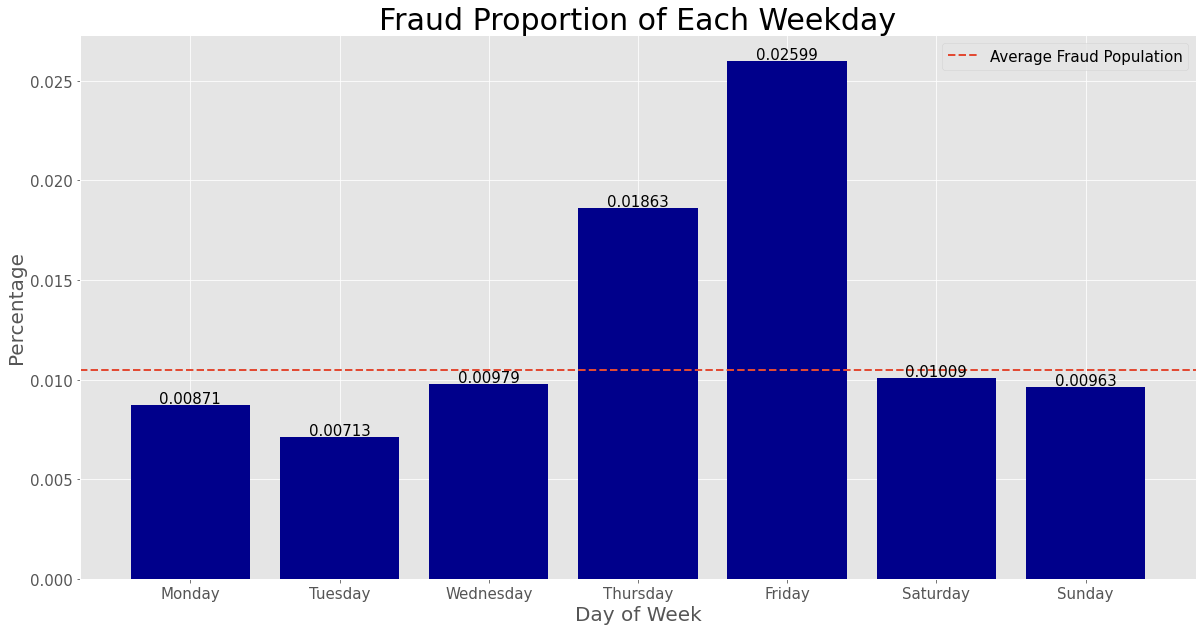

In [41]:
# plot
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (20, 10))
plt.bar(data = y_dow, x = y_dow.index, height = 'Fraud', color = 'darkblue')
ax.axhline(y = y_avg, ls = '--', lw = 2, label = 'Average Fraud Population')

for i, v in enumerate(y_dow.index):
    ax.text(v, y_dow.loc[v, 'Fraud'] + 0.0001, round(y_dow.loc[v, 'Fraud'], 5),
           horizontalalignment = 'center', fontsize = 15)

plt.legend(['Average Fraud Population'], fontsize = 15)
plt.xlabel('Day of Week', fontsize = 20)
plt.ylabel('Percentage', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Fraud Proportion of Each Weekday', fontsize = 30)
plt.show()

## Make new entities for variables

In [42]:
# convert to string to concatenate
df['Merch zip'] = df['Merch zip'].astype(str)

In [43]:
df['card_merch'] = df['Cardnum'] + df['Merchnum']
df['card_zip'] = df['Cardnum'] + df['Merch zip']
df['merch_zip'] = df['Merchnum'] + df['Merch zip']
df['zip3'] = df['Merch zip'].str[:3]
df['card_zip3'] = df['Cardnum'] + df['zip3']
df['Card_Merchdesc'] = df['Cardnum'] + df['Merch description']
df['Merchnum_desc'] = df['Merchnum'] + df['Merch description']
df['Card_Merchnum_desc'] = df['Cardnum'] + df['Merchnum'] + df['Merch description']

In [44]:
df.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud', 'Dow',
       'Dow_risk', 'card_merch', 'card_zip', 'merch_zip', 'zip3', 'card_zip3',
       'Card_Merchdesc', 'Merchnum_desc', 'Card_Merchnum_desc'],
      dtype='object')

In [45]:
entities = list(df.iloc[:, np.r_[1, 3, 12:20]].columns)

In [46]:
entities

['Cardnum',
 'Merchnum',
 'card_merch',
 'card_zip',
 'merch_zip',
 'zip3',
 'card_zip3',
 'Card_Merchdesc',
 'Merchnum_desc',
 'Card_Merchnum_desc']

In [47]:
len(entities)

10

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96752
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Recnum              96397 non-null  int64         
 1   Cardnum             96397 non-null  object        
 2   Date                96397 non-null  datetime64[ns]
 3   Merchnum            96397 non-null  object        
 4   Merch description   96397 non-null  object        
 5   Merch state         96397 non-null  object        
 6   Merch zip           96397 non-null  object        
 7   Transtype           96397 non-null  object        
 8   Amount              96397 non-null  float64       
 9   Fraud               96397 non-null  int64         
 10  Dow                 96397 non-null  object        
 11  Dow_risk            96397 non-null  float64       
 12  card_merch          96397 non-null  object        
 13  card_zip            96397 non-null  object    

In [49]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Dow,Dow_risk,card_merch,card_zip,merch_zip,zip3,card_zip3,Card_Merchdesc,Merchnum_desc,Card_Merchnum_desc
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994,51421904395509006296254,514219043938118.0,550900629625438118.0,381,5142190439381,5142190439FEDEX SHP 12/23/09 AB#,5509006296254FEDEX SHP 12/23/09 AB#,51421904395509006296254FEDEX SHP 12/23/09 AB#
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Friday,0.025994,514218397361003026333,51421839731803.0,610030263331803.0,180,5142183973180,5142183973SERVICE MERCHANDISE #81,61003026333SERVICE MERCHANDISE #81,514218397361003026333SERVICE MERCHANDISE #81
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Friday,0.025994,51421317214503082993600,514213172120706.0,450308299360020706.0,207,5142131721207,5142131721OFFICE DEPOT #191,4503082993600OFFICE DEPOT #191,51421317214503082993600OFFICE DEPOT #191
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994,51421484525509006296254,514214845238118.0,550900629625438118.0,381,5142148452381,5142148452FEDEX SHP 12/28/09 AB#,5509006296254FEDEX SHP 12/28/09 AB#,51421484525509006296254FEDEX SHP 12/28/09 AB#
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994,51421904395509006296254,514219043938118.0,550900629625438118.0,381,5142190439381,5142190439FEDEX SHP 12/23/09 AB#,5509006296254FEDEX SHP 12/23/09 AB#,51421904395509006296254FEDEX SHP 12/23/09 AB#


## Benford's law variables

In [50]:
bf = data.copy()
bf['amount_100'] = (bf['Amount'] * 100).astype(str)
bf['first_digit'] = bf['amount_100'].str[0]

In [51]:
# remove FEDEX first only for this part
dropfedex = bf[bf['Merch description'].str.contains('FEDEX')]
droplist = dropfedex.index.tolist()
bf1 = bf.drop(droplist)
bf1['bin'] = bf1['first_digit'].apply(lambda x: 'low' if x == '1' else
                                     ('low' if x == '2' else 'high'))

### U*'s for card numbers

In [52]:
card_bf = bf1.groupby(['Cardnum', 'bin']).agg({'bin': ['count']}).reset_index()
card_bf.columns = ['Cardnum', 'bin', 'count']
card_bf = card_bf.pivot_table(index = 'Cardnum', columns = 'bin', values = 'count', 
                             aggfunc = 'sum').reset_index()
card_bf.columns = ['Cardnum', 'n_high', 'n_low']
card_bf = card_bf.fillna(1)

In [53]:
# calculate R, 1/R, U, n, t, U*
c = 3
n_mid = 15
card_bf['R'] = (1.096 * card_bf['n_low']/ card_bf['n_high'])
card_bf['1/R'] = (1/ card_bf['R'])
card_bf['U'] = list(map(lambda x, y : max(x, y), card_bf['R'], card_bf['1/R']))
card_bf['n'] = card_bf['n_high'] + card_bf['n_low']
card_bf['t'] = ((card_bf['n'] - n_mid)/ c)
card_bf['U*'] = list(map(lambda x, y : (1 + (x - 1)/ (1 + np.exp(-y))), 
                        card_bf['U'], card_bf['t']))

In [54]:
card_bf['Cardnum'] = card_bf['Cardnum'].apply(str)
card_bf.set_index('Cardnum', inplace = True)
card_Ustar = pd.DataFrame(card_bf['U*'])
card_Ustar.sort_values(['U*'], ascending = False).head(3)

,U*
Cardnum,
5142253356,13.371199
5142299705,9.027976
5142197563,8.150852


### U*'s for merchant numbers

In [55]:
merch_bf = bf1.groupby(['Merchnum', 'bin']).agg({'bin': ['count']}).reset_index()
merch_bf.columns = ['Merchnum', 'bin', 'count']
merch_bf = merch_bf.pivot_table(index = 'Merchnum', columns = 'bin', values = 'count', 
                             aggfunc = 'sum').reset_index()
merch_bf.columns = ['Merchnum', 'n_high', 'n_low']
merch_bf = merch_bf.fillna(1)

In [56]:
# calculate R, 1/R, U, n, t, U*
merch_bf['R'] = (1.096 * merch_bf['n_low']/ merch_bf['n_high'])
merch_bf['1/R'] = (1/ merch_bf['R'])
merch_bf['U'] = list(map(lambda x, y : max(x, y), merch_bf['R'], merch_bf['1/R']))
merch_bf['n'] = merch_bf['n_high'] + merch_bf['n_low']
merch_bf['t'] = ((merch_bf['n'] - n_mid)/ c)
merch_bf['U*'] = list(map(lambda x, y : (1 + (x - 1)/ (1 + np.exp(-y))), 
                        merch_bf['U'], merch_bf['t']))

In [57]:
merch_bf['Merchnum'] = merch_bf['Merchnum'].apply(str)
merch_bf.set_index('Merchnum', inplace = True)
merch_Ustar = pd.DataFrame(merch_bf['U*'])
merch_Ustar.sort_values(['U*'], ascending = False).head(3)

,U*
Merchnum,
991808369338,165.145985
8078200641472,64.663981
308904389335,48.357557


### Merge Benford's law variables with dataset

In [58]:
df = df.merge(card_Ustar, how = 'left', left_on = 'Cardnum', right_on = card_Ustar.index)
df = df.rename(columns = {'U*': 'U*_cardnum'})
df = df.merge(merch_Ustar, how = 'left', left_on = 'Merchnum', right_on = merch_Ustar.index)
df = df.rename(columns = {'U*': 'U*_merchnum'})

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96397 entries, 0 to 96396
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Recnum              96397 non-null  int64         
 1   Cardnum             96397 non-null  object        
 2   Date                96397 non-null  datetime64[ns]
 3   Merchnum            96397 non-null  object        
 4   Merch description   96397 non-null  object        
 5   Merch state         96397 non-null  object        
 6   Merch zip           96397 non-null  object        
 7   Transtype           96397 non-null  object        
 8   Amount              96397 non-null  float64       
 9   Fraud               96397 non-null  int64         
 10  Dow                 96397 non-null  object        
 11  Dow_risk            96397 non-null  float64       
 12  card_merch          96397 non-null  object        
 13  card_zip            96397 non-null  object    

In [60]:
df = df.fillna(1)
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,card_merch,card_zip,merch_zip,zip3,card_zip3,Card_Merchdesc,Merchnum_desc,Card_Merchnum_desc,U*_cardnum,U*_merchnum
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,51421904395509006296254,514219043938118.0,550900629625438118.0,381,5142190439381,5142190439FEDEX SHP 12/23/09 AB#,5509006296254FEDEX SHP 12/23/09 AB#,51421904395509006296254FEDEX SHP 12/23/09 AB#,2.178008,1.000000
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,514218397361003026333,51421839731803.0,610030263331803.0,180,5142183973180,5142183973SERVICE MERCHANDISE #81,61003026333SERVICE MERCHANDISE #81,514218397361003026333SERVICE MERCHANDISE #81,1.604857,1.001244
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,51421317214503082993600,514213172120706.0,450308299360020706.0,207,5142131721207,5142131721OFFICE DEPOT #191,4503082993600OFFICE DEPOT #191,51421317214503082993600OFFICE DEPOT #191,2.368143,1.025818
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,51421484525509006296254,514214845238118.0,550900629625438118.0,381,5142148452381,5142148452FEDEX SHP 12/28/09 AB#,5509006296254FEDEX SHP 12/28/09 AB#,51421484525509006296254FEDEX SHP 12/28/09 AB#,1.044105,1.000000
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,51421904395509006296254,514219043938118.0,550900629625438118.0,381,5142190439381,5142190439FEDEX SHP 12/23/09 AB#,5509006296254FEDEX SHP 12/23/09 AB#,51421904395509006296254FEDEX SHP 12/23/09 AB#,2.178008,1.000000


## Velocity/counts and days since variables

In [61]:
# check point
df1 = df.copy()
final = df.copy()
df1['check_date'] = df1.Date
df1['check_record'] = df1.Recnum

In [62]:
varnum = len(final.columns) - 19
varnum

3

In [63]:
start = timeit.default_timer()
for entity in entities:    
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: print('')
    st = timeit.default_timer()    
    ## Day-since variables:   
    df_l = df1[['Recnum', 'Date', entity]]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]    
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)   
    temp1 = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
                                                   .groupby('Recnum')[['Date', 'check_date']].last()
    mapper = (temp1.Date - temp1.check_date).dt.days
    final[entity + '_day_since'] = final.Recnum.map(mapper)
    final[entity + '_day_since'].fillna((final.Date - pd.to_datetime('2010-01-01')).dt.days, inplace = True)
    print('\n' + entity + '_day_since ---> Done')   
    ## Frequency & Amount variables:   
    for time in [0,1,3,7,14,30]:       
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]       
        col_name = entity + '_count_' + str(time)    
        mapper2 = temp2.groupby('Recnum')[entity].count()      
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')       
        final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
        final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
        final[entity + '_actual/med_' + str(time)] = final['Amount'] / final[entity + '_med_' + str(time)]
        final[entity + '_actual/toal_' + str(time)] = final['Amount'] / final[entity + '_total_' + str(time)]       
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')



Cardnum_day_since ---> Done
Cardnum_count_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_count_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_count_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_count_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_count_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_count_30 ---> Done
Cardnum amount variables over past 30 ---> Done
Run time for the last entity ----------------- 4.6088453s

Merchnum_day_since ---> Done
Merchnum_count_0 ---> Done
Merchnum amount variables over past 0 ---> Done
Merchnum_count_1 ---> Done
Merchnum amount variables over past 1 ---> Done
Merchnum_count_3 ---> Done
Merchnum amount variables over past 3 ---> Done
Merchnum_count_7 ---> Done
Merchnum amount variables over past 7 ---> Done
Merchnum_count_14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:29: PerformanceWarning: DataFrame is hi

Merchnum amount variables over past 14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


Merchnum_count_30 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:26: PerformanceWarning: DataFrame is highly

Merchnum amount variables over past 30 ---> Done
Run time for the last entity ----------------- 25.176485999999997s


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_day_since'] = final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor


card_merch_day_since ---> Done
card_merch_count_0 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is high

card_merch amount variables over past 0 ---> Done
card_merch_count_1 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:26: PerformanceWarning: DataFrame is highly

card_merch amount variables over past 1 ---> Done
card_merch_count_3 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

card_merch amount variables over past 3 ---> Done
card_merch_count_7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

card_merch amount variables over past 7 ---> Done
card_merch_count_14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

card_merch amount variables over past 14 ---> Done
card_merch_count_30 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:28: PerformanceWarning: DataFrame is hi

card_merch amount variables over past 30 ---> Done
Run time for the last entity ----------------- 2.8692256s


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_day_since'] = final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor


card_zip_day_since ---> Done
card_zip_count_0 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:28: PerformanceWarning: DataFrame is hi

card_zip amount variables over past 0 ---> Done
card_zip_count_1 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

card_zip amount variables over past 1 ---> Done
card_zip_count_3 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

card_zip amount variables over past 3 ---> Done
card_zip_count_7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

card_zip amount variables over past 7 ---> Done
card_zip_count_14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

card_zip amount variables over past 14 ---> Done
card_zip_count_30 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

card_zip amount variables over past 30 ---> Done
Run time for the last entity ----------------- 2.231068200000003s


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_day_since'] = final.Recnum.map(mapper)



merch_zip_day_since ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

merch_zip_count_0 ---> Done
merch_zip amount variables over past 0 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

merch_zip_count_1 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:30: PerformanceWarning: DataFrame is h

merch_zip amount variables over past 1 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

merch_zip_count_3 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:28: PerformanceWarning: DataFrame is hi

merch_zip amount variables over past 3 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

merch_zip_count_7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:28: PerformanceWarning: DataFrame is hi

merch_zip amount variables over past 7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())


merch_zip_count_14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is high

merch_zip amount variables over past 14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_zip_count_30 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:26: PerformanceWarning: DataFrame is highly

merch_zip amount variables over past 30 ---> Done
Run time for the last entity ----------------- 23.315675399999996s


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_day_since'] = final.Recnum.map(mapper)



zip3_day_since ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

zip3_count_0 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:29: PerformanceWarning: DataFrame is hi

zip3 amount variables over past 0 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

zip3_count_1 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:29: PerformanceWarning: DataFrame is hi

zip3 amount variables over past 1 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

zip3_count_3 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:28: PerformanceWarning: DataFrame is hi

zip3 amount variables over past 3 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())


zip3_count_7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is high

zip3 amount variables over past 7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())


zip3_count_14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is high

zip3 amount variables over past 14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


zip3_count_30 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:26: PerformanceWarning: DataFrame is highly

zip3 amount variables over past 30 ---> Done
Run time for the last entity ----------------- 51.98493540000001s


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_day_since'] = final.Recnum.map(mapper)



card_zip3_day_since ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

card_zip3_count_0 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/toal_' + str(time)] = final['Amount'] / final[entity + '_total_' + str(time)]
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

card_zip3 amount variables over past 0 ---> Done
card_zip3_count_1 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is high

card_zip3 amount variables over past 1 ---> Done
card_zip3_count_3 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

card_zip3 amount variables over past 3 ---> Done
card_zip3_count_7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

card_zip3 amount variables over past 7 ---> Done
card_zip3_count_14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:26: PerformanceWarning: DataFrame is highly

card_zip3 amount variables over past 14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

card_zip3_count_30 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:30: PerformanceWarning: DataFrame is h

card_zip3 amount variables over past 30 ---> Done
Run time for the last entity ----------------- 4.308770299999992s


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_day_since'] = final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor


Card_Merchdesc_day_since ---> Done
Card_Merchdesc_count_0 ---> Done
Card_Merchdesc amount variables over past 0 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

Card_Merchdesc_count_1 ---> Done
Card_Merchdesc amount variables over past 1 ---> Done
Card_Merchdesc_count_3 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is high

Card_Merchdesc amount variables over past 3 ---> Done
Card_Merchdesc_count_7 ---> Done
Card_Merchdesc amount variables over past 7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:29: PerformanceWarning: DataFrame is hi

Card_Merchdesc_count_14 ---> Done
Card_Merchdesc amount variables over past 14 ---> Done
Card_Merchdesc_count_30 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:30: PerformanceWarning: DataFrame is h

Card_Merchdesc amount variables over past 30 ---> Done
Run time for the last entity ----------------- 1.2843388000000004s


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_day_since'] = final.Recnum.map(mapper)



Merchnum_desc_day_since ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

Merchnum_desc_count_0 ---> Done
Merchnum_desc amount variables over past 0 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

Merchnum_desc_count_1 ---> Done
Merchnum_desc amount variables over past 1 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

Merchnum_desc_count_3 ---> Done
Merchnum_desc amount variables over past 3 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

Merchnum_desc_count_7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/med_' + str(time)] = final['Amount'] / final[entity + '_med_' + str(time)]
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/toal_' + str(time)] = final['Amount'] / final[entity + '_total_' + str(time)]


Merchnum_desc amount variables over past 7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

Merchnum_desc_count_14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:30: PerformanceWarning: DataFrame is h

Merchnum_desc amount variables over past 14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

Merchnum_desc_count_30 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:29: PerformanceWarning: DataFrame is hi

Merchnum_desc amount variables over past 30 ---> Done
Run time for the last entity ----------------- 4.473524500000011s


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_day_since'] = final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor


Card_Merchnum_desc_day_since ---> Done
Card_Merchnum_desc_count_0 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/med_' + str(time)] = final['Amount'] / final[entity + '_med_' + str(time)]
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:31: PerformanceWarning: DataFrame is h

Card_Merchnum_desc amount variables over past 0 ---> Done
Card_Merchnum_desc_count_1 ---> Done
Card_Merchnum_desc amount variables over past 1 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

Card_Merchnum_desc_count_3 ---> Done
Card_Merchnum_desc amount variables over past 3 ---> Done
Card_Merchnum_desc_count_7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is high

Card_Merchnum_desc amount variables over past 7 ---> Done
Card_Merchnum_desc_count_14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:28: PerformanceWarning: DataFrame is hi

Card_Merchnum_desc amount variables over past 14 ---> Done
Card_Merchnum_desc_count_30 ---> Done
Card_Merchnum_desc amount variables over past 30 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\783239204.py:29: PerformanceWarning: DataFrame is hi

In [64]:
newvars = len(final.columns) - 19 - varnum
newvars

550

In [69]:
varnum = len(final.columns) - 19
varnum

553

In [70]:
start = timeit.default_timer()
# velocity change variables
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30']:
            final[ent + '_count_' + d + '_by_' + dd] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/float(dd)

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3282759089.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd] =\
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3282759089.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd] =\
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3282759089.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3282759089.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd] =\
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3282759089.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd] =\
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3282759089.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3282759089.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd] =\
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3282759089.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd] =\
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3282759089.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

In [71]:
newvars = len(final.columns) - 19 - varnum
newvars

60

In [72]:
varnum = len(final.columns) - 19
varnum

613

In [73]:
start = timeit.default_timer()
# velocity days since ratio
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30']:
            final[ent + '_vdratio_' + d  + 'by' + dd] =\
            final[ent + '_count_' + d + '_by_' + dd]/(final[ent + '_day_since']+1)

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3320304332.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_vdratio_' + d  + 'by' + dd] =\
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3320304332.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_vdratio_' + d  + 'by' + dd] =\
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3320304332.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3320304332.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_vdratio_' + d  + 'by' + dd] =\
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3320304332.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_vdratio_' + d  + 'by' + dd] =\
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3320304332.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3320304332.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_vdratio_' + d  + 'by' + dd] =\
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3320304332.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_vdratio_' + d  + 'by' + dd] =\
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3320304332.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performan

In [74]:
newvars = len(final.columns) - 19 - varnum
newvars

60

In [75]:
len(final.columns)

692

## Entities variables

In [76]:
varnum = len(final.columns) - 19
varnum

673

In [77]:
# unique entity counts
for i in entities:
    for v in entities:
        if i==v:
            continue
        else:
            df_c=df1[['Recnum','Date',i]]
            df_d=df1[['check_record','check_date',i,v]]
            temp=pd.merge(df_c,df_d,left_on=i,right_on=i)
            
        for t in [1,3,7,14,30,60]:
            count_day_df=temp[(temp.check_date>=(temp.Date-dt.timedelta(t)))&(temp.Recnum>=temp.check_record)]
            col_name=f'{i}_unique_count_for_{v}_{t}'
            mapper=count_day_df.groupby(['Recnum'])[v].nunique()
            final[col_name]=final.Recnum.map(mapper)

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name]=final.Recnum.map(mapper)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\1564456075.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

In [78]:
newvars = len(final.columns) - 19 - varnum
newvars

540

In [82]:
varnum = len(final.columns) - 19
varnum

1213

In [83]:
# variability
for entity in entities:
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: 
        print('')
    st = timeit.default_timer() 
    df_l = df1[['Recnum', 'Date', entity,'Amount']]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
    
    for time in [0,1,3,7,14,30]:
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', 'check_record',entity, 'Amount_x','Amount_y']]
        temp2['Amount_diff']=temp2['Amount_y']-temp2['Amount_x']

        col_name = entity + '_variability_avg_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].mean()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        col_name = entity + '_variability_max_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].max()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        col_name = entity + '_variability_med_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].median()
        final[col_name] = final.Recnum.map(mapper2)        
        print(col_name + ' ---> Done')
        
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')

Run time for the last entity ----------------- 1389.9730327s


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Cardnum_variability_avg_0 ---> Done
Cardnum_variability_max_0 ---> Done
Cardnum_variability_med_0 ---> Done
Cardnum amount variables over past 0 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Cardnum_variability_avg_1 ---> Done
Cardnum_variability_max_1 ---> Done
Cardnum_variability_med_1 ---> Done
Cardnum amount variables over past 1 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Cardnum_variability_avg_3 ---> Done
Cardnum_variability_max_3 ---> Done
Cardnum_variability_med_3 ---> Done
Cardnum amount variables over past 3 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Cardnum_variability_avg_7 ---> Done
Cardnum_variability_max_7 ---> Done
Cardnum_variability_med_7 ---> Done
Cardnum amount variables over past 7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Cardnum_variability_avg_14 ---> Done
Cardnum_variability_max_14 ---> Done
Cardnum_variability_med_14 ---> Done
Cardnum amount variables over past 14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Cardnum_variability_avg_30 ---> Done
Cardnum_variability_max_30 ---> Done
Cardnum_variability_med_30 ---> Done
Cardnum amount variables over past 30 ---> Done
Run time for the last entity ----------------- 3.62767040000017s


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Merchnum_variability_avg_0 ---> Done
Merchnum_variability_max_0 ---> Done
Merchnum_variability_med_0 ---> Done
Merchnum amount variables over past 0 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Merchnum_variability_avg_1 ---> Done
Merchnum_variability_max_1 ---> Done
Merchnum_variability_med_1 ---> Done
Merchnum amount variables over past 1 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Merchnum_variability_avg_3 ---> Done
Merchnum_variability_max_3 ---> Done
Merchnum_variability_med_3 ---> Done
Merchnum amount variables over past 3 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Merchnum_variability_avg_7 ---> Done
Merchnum_variability_max_7 ---> Done
Merchnum_variability_med_7 ---> Done
Merchnum amount variables over past 7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


Merchnum_variability_avg_14 ---> Done
Merchnum_variability_max_14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


Merchnum_variability_med_14 ---> Done
Merchnum amount variables over past 14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


Merchnum_variability_avg_30 ---> Done
Merchnum_variability_max_30 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


Merchnum_variability_med_30 ---> Done
Merchnum amount variables over past 30 ---> Done
Run time for the last entity ----------------- 17.648566399999936s


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

card_merch_variability_avg_0 ---> Done
card_merch_variability_max_0 ---> Done
card_merch_variability_med_0 ---> Done
card_merch amount variables over past 0 ---> Done
card_merch_variability_avg_1 ---> Done
card_merch_variability_max_1 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

card_merch_variability_med_1 ---> Done
card_merch amount variables over past 1 ---> Done
card_merch_variability_avg_3 ---> Done
card_merch_variability_max_3 ---> Done
card_merch_variability_med_3 ---> Done
card_merch amount variables over past 3 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

card_merch_variability_avg_7 ---> Done
card_merch_variability_max_7 ---> Done
card_merch_variability_med_7 ---> Done
card_merch amount variables over past 7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

card_merch_variability_avg_14 ---> Done
card_merch_variability_max_14 ---> Done
card_merch_variability_med_14 ---> Done
card_merch amount variables over past 14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

card_merch_variability_avg_30 ---> Done
card_merch_variability_max_30 ---> Done
card_merch_variability_med_30 ---> Done
card_merch amount variables over past 30 ---> Done
Run time for the last entity ----------------- 2.160459200000105s


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

card_zip_variability_avg_0 ---> Done
card_zip_variability_max_0 ---> Done
card_zip_variability_med_0 ---> Done
card_zip amount variables over past 0 ---> Done
card_zip_variability_avg_1 ---> Done
card_zip_variability_max_1 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

card_zip_variability_med_1 ---> Done
card_zip amount variables over past 1 ---> Done
card_zip_variability_avg_3 ---> Done
card_zip_variability_max_3 ---> Done
card_zip_variability_med_3 ---> Done
card_zip amount variables over past 3 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

card_zip_variability_avg_7 ---> Done
card_zip_variability_max_7 ---> Done
card_zip_variability_med_7 ---> Done
card_zip amount variables over past 7 ---> Done
card_zip_variability_avg_14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

card_zip_variability_max_14 ---> Done
card_zip_variability_med_14 ---> Done
card_zip amount variables over past 14 ---> Done
card_zip_variability_avg_30 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


card_zip_variability_max_30 ---> Done
card_zip_variability_med_30 ---> Done
card_zip amount variables over past 30 ---> Done
Run time for the last entity ----------------- 1.4516388000001825s


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

merch_zip_variability_avg_0 ---> Done
merch_zip_variability_max_0 ---> Done
merch_zip_variability_med_0 ---> Done
merch_zip amount variables over past 0 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

merch_zip_variability_avg_1 ---> Done
merch_zip_variability_max_1 ---> Done
merch_zip_variability_med_1 ---> Done
merch_zip amount variables over past 1 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

merch_zip_variability_avg_3 ---> Done
merch_zip_variability_max_3 ---> Done
merch_zip_variability_med_3 ---> Done
merch_zip amount variables over past 3 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

merch_zip_variability_avg_7 ---> Done
merch_zip_variability_max_7 ---> Done
merch_zip_variability_med_7 ---> Done
merch_zip amount variables over past 7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_zip_variability_avg_14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_zip_variability_max_14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_zip_variability_med_14 ---> Done
merch_zip amount variables over past 14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_zip_variability_avg_30 ---> Done
merch_zip_variability_max_30 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


merch_zip_variability_med_30 ---> Done
merch_zip amount variables over past 30 ---> Done
Run time for the last entity ----------------- 17.76813549999997s


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

zip3_variability_avg_0 ---> Done
zip3_variability_max_0 ---> Done
zip3_variability_med_0 ---> Done
zip3 amount variables over past 0 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

zip3_variability_avg_1 ---> Done
zip3_variability_max_1 ---> Done
zip3_variability_med_1 ---> Done
zip3 amount variables over past 1 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

zip3_variability_avg_3 ---> Done
zip3_variability_max_3 ---> Done
zip3_variability_med_3 ---> Done
zip3 amount variables over past 3 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


zip3_variability_avg_7 ---> Done
zip3_variability_max_7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


zip3_variability_med_7 ---> Done
zip3 amount variables over past 7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


zip3_variability_avg_14 ---> Done
zip3_variability_max_14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


zip3_variability_med_14 ---> Done
zip3 amount variables over past 14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


zip3_variability_avg_30 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


zip3_variability_max_30 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


zip3_variability_med_30 ---> Done
zip3 amount variables over past 30 ---> Done
Run time for the last entity ----------------- 49.20939229999999s


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

card_zip3_variability_avg_0 ---> Done
card_zip3_variability_max_0 ---> Done
card_zip3_variability_med_0 ---> Done
card_zip3 amount variables over past 0 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

card_zip3_variability_avg_1 ---> Done
card_zip3_variability_max_1 ---> Done
card_zip3_variability_med_1 ---> Done
card_zip3 amount variables over past 1 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

card_zip3_variability_avg_3 ---> Done
card_zip3_variability_max_3 ---> Done
card_zip3_variability_med_3 ---> Done
card_zip3 amount variables over past 3 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

card_zip3_variability_avg_7 ---> Done
card_zip3_variability_max_7 ---> Done
card_zip3_variability_med_7 ---> Done
card_zip3 amount variables over past 7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

card_zip3_variability_avg_14 ---> Done
card_zip3_variability_max_14 ---> Done
card_zip3_variability_med_14 ---> Done
card_zip3 amount variables over past 14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

card_zip3_variability_avg_30 ---> Done
card_zip3_variability_max_30 ---> Done
card_zip3_variability_med_30 ---> Done
card_zip3 amount variables over past 30 ---> Done
Run time for the last entity ----------------- 4.2713072999999895s


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Card_Merchdesc_variability_avg_0 ---> Done
Card_Merchdesc_variability_max_0 ---> Done
Card_Merchdesc_variability_med_0 ---> Done
Card_Merchdesc amount variables over past 0 ---> Done
Card_Merchdesc_variability_avg_1 ---> Done
Card_Merchdesc_variability_max_1 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Card_Merchdesc_variability_med_1 ---> Done
Card_Merchdesc amount variables over past 1 ---> Done
Card_Merchdesc_variability_avg_3 ---> Done
Card_Merchdesc_variability_max_3 ---> Done
Card_Merchdesc_variability_med_3 ---> Done
Card_Merchdesc amount variables over past 3 ---> Done
Card_Merchdesc_variability_avg_7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Card_Merchdesc_variability_max_7 ---> Done
Card_Merchdesc_variability_med_7 ---> Done
Card_Merchdesc amount variables over past 7 ---> Done
Card_Merchdesc_variability_avg_14 ---> Done
Card_Merchdesc_variability_max_14 ---> Done
Card_Merchdesc_variability_med_14 ---> Done
Card_Merchdesc amount variables over past 14 ---> Done
Card_Merchdesc_variability_avg_30 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)


Card_Merchdesc_variability_max_30 ---> Done
Card_Merchdesc_variability_med_30 ---> Done
Card_Merchdesc amount variables over past 30 ---> Done
Run time for the last entity ----------------- 0.9546155000000454s


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Merchnum_desc_variability_avg_0 ---> Done
Merchnum_desc_variability_max_0 ---> Done
Merchnum_desc_variability_med_0 ---> Done
Merchnum_desc amount variables over past 0 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Merchnum_desc_variability_avg_1 ---> Done
Merchnum_desc_variability_max_1 ---> Done
Merchnum_desc_variability_med_1 ---> Done
Merchnum_desc amount variables over past 1 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Merchnum_desc_variability_avg_3 ---> Done
Merchnum_desc_variability_max_3 ---> Done
Merchnum_desc_variability_med_3 ---> Done
Merchnum_desc amount variables over past 3 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Merchnum_desc_variability_avg_7 ---> Done
Merchnum_desc_variability_max_7 ---> Done
Merchnum_desc_variability_med_7 ---> Done
Merchnum_desc amount variables over past 7 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Merchnum_desc_variability_avg_14 ---> Done
Merchnum_desc_variability_max_14 ---> Done
Merchnum_desc_variability_med_14 ---> Done
Merchnum_desc amount variables over past 14 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Merchnum_desc_variability_avg_30 ---> Done
Merchnum_desc_variability_max_30 ---> Done
Merchnum_desc_variability_med_30 ---> Done
Merchnum_desc amount variables over past 30 ---> Done
Run time for the last entity ----------------- 3.3956929000000855s


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Card_Merchnum_desc_variability_avg_0 ---> Done
Card_Merchnum_desc_variability_max_0 ---> Done
Card_Merchnum_desc_variability_med_0 ---> Done
Card_Merchnum_desc amount variables over past 0 ---> Done
Card_Merchnum_desc_variability_avg_1 ---> Done
Card_Merchnum_desc_variability_max_1 ---> Done
Card_Merchnum_desc_variability_med_1 ---> Done
Card_Merchnum_desc amount variables over past 1 ---> Done
Card_Merchnum_desc_variability_avg_3 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Card_Merchnum_desc_variability_max_3 ---> Done
Card_Merchnum_desc_variability_med_3 ---> Done
Card_Merchnum_desc amount variables over past 3 ---> Done
Card_Merchnum_desc_variability_avg_7 ---> Done
Card_Merchnum_desc_variability_max_7 ---> Done
Card_Merchnum_desc_variability_med_7 ---> Done
Card_Merchnum_desc amount variables over past 7 ---> Done
Card_Merchnum_desc_variability_avg_14 ---> Done
Card_Merchnum_desc_variability_max_14 ---> Done
Card_Merchnum_desc_variability_med_14 ---> Done
Card_Merchnum_desc amount variables over past 14 ---> Done
Card_Merchnum_desc_variability_avg_30 ---> Done
Card_Merchnum_desc_variability_max_30 ---> Done
Card_Merchnum_desc_variability_med_30 ---> Done
Card_Merchnum_desc amount variables over past 30 ---> Done


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[col_name] = final.Recnum.map(mapper2)
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2659022082.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

In [84]:
newvars = len(final.columns) - 19 - varnum
newvars

180

In [85]:
len(final.columns)

1412

In [86]:
print('time to here: ',dt.datetime.now() - start_time)

time to here:  0:26:54.940741


## Other variables

In [87]:
varnum = len(final.columns) - 19
varnum

1393

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\2551397364.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final['amount_cat'] = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5])


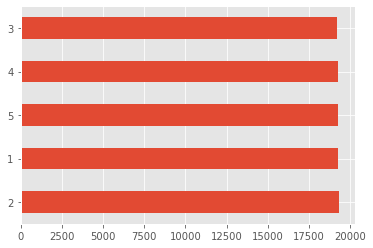

In [88]:
# Amount bins
AMOUNT = True
if AMOUNT:
      final['amount_cat'] = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5])
      
      final['amount_cat'].value_counts().plot(kind='barh')
      plt.show()
      
      qcut_series, qcut_intervals = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5],retbins=True)
      
      qcut_series.value_counts()

In [89]:
newvars = len(final.columns) - 19 - varnum
newvars

1

In [90]:
varnum = len(final.columns) - 19
varnum

1394

In [91]:
# acceleration
for ent in entities:
    print(ent)
    for d in ['0', '1']:
        for dd in ['7', '14', '30']:
            final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/pow(float(dd),2)

Cardnum
Merchnum
card_merch
card_zip


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3361502282.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3361502282.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3361502282.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3361502282.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3361502282.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3361502282.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

merch_zip
zip3
card_zip3
Card_Merchdesc
Merchnum_desc
Card_Merchnum_desc


C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3361502282.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3361502282.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
C:\Users\Alex Tan\AppData\Local\Temp\ipykernel_15732\3361502282.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

In [92]:
newvars = len(final.columns) - 19 - varnum
newvars

60

In [93]:
varnum = len(final.columns) - 19
varnum

1454

# Deduplicate variables

In [94]:
backup = final.copy()

In [95]:
%%time
print(final.shape)
final = final.T.drop_duplicates().T
final.shape

(96397, 1473)
CPU times: total: 31.6 s
Wall time: 31.6 s


(96397, 1210)

In [96]:
len(final.columns) - 19

1191

In [97]:
final.columns.to_list()

['Recnum',
 'Cardnum',
 'Date',
 'Merchnum',
 'Merch description',
 'Merch state',
 'Merch zip',
 'Transtype',
 'Amount',
 'Fraud',
 'Dow',
 'Dow_risk',
 'card_merch',
 'card_zip',
 'merch_zip',
 'zip3',
 'card_zip3',
 'Card_Merchdesc',
 'Merchnum_desc',
 'Card_Merchnum_desc',
 'U*_cardnum',
 'U*_merchnum',
 'Cardnum_day_since',
 'Cardnum_count_0',
 'Cardnum_avg_0',
 'Cardnum_max_0',
 'Cardnum_med_0',
 'Cardnum_total_0',
 'Cardnum_actual/avg_0',
 'Cardnum_actual/max_0',
 'Cardnum_actual/med_0',
 'Cardnum_actual/toal_0',
 'Cardnum_count_1',
 'Cardnum_avg_1',
 'Cardnum_max_1',
 'Cardnum_med_1',
 'Cardnum_total_1',
 'Cardnum_actual/avg_1',
 'Cardnum_actual/max_1',
 'Cardnum_actual/med_1',
 'Cardnum_actual/toal_1',
 'Cardnum_count_3',
 'Cardnum_avg_3',
 'Cardnum_max_3',
 'Cardnum_med_3',
 'Cardnum_total_3',
 'Cardnum_actual/avg_3',
 'Cardnum_actual/max_3',
 'Cardnum_actual/med_3',
 'Cardnum_actual/toal_3',
 'Cardnum_count_7',
 'Cardnum_avg_7',
 'Cardnum_max_7',
 'Cardnum_med_7',
 'Cardnum_

In [98]:
final.shape

(96397, 1210)

In [99]:
print('duration: ',dt.datetime.now() - start_time)

duration:  0:27:29.982824


In [100]:
final.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,Merchnum_desc_count_0_by_30_sq,Merchnum_desc_count_1_by_7_sq,Merchnum_desc_count_1_by_14_sq,Merchnum_desc_count_1_by_30_sq,Card_Merchnum_desc_count_0_by_7_sq,Card_Merchnum_desc_count_0_by_14_sq,Card_Merchnum_desc_count_0_by_30_sq,Card_Merchnum_desc_count_1_by_7_sq,Card_Merchnum_desc_count_1_by_14_sq,Card_Merchnum_desc_count_1_by_30_sq
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111


In [101]:
%%time
final.drop(columns=entities, inplace=True)
final.head()

CPU times: total: 562 ms
Wall time: 561 ms


,Recnum,Date,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Dow,Dow_risk,...,Merchnum_desc_count_0_by_30_sq,Merchnum_desc_count_1_by_7_sq,Merchnum_desc_count_1_by_14_sq,Merchnum_desc_count_1_by_30_sq,Card_Merchnum_desc_count_0_by_7_sq,Card_Merchnum_desc_count_0_by_14_sq,Card_Merchnum_desc_count_0_by_30_sq,Card_Merchnum_desc_count_1_by_7_sq,Card_Merchnum_desc_count_1_by_14_sq,Card_Merchnum_desc_count_1_by_30_sq
0,1,2010-01-01,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
1,2,2010-01-01,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Friday,0.025994,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
2,3,2010-01-01,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Friday,0.025994,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
3,4,2010-01-01,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
4,5,2010-01-01,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.025994,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111


In [102]:
%%time
final.drop(columns=['Date','Merch description', 'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Dow'], inplace=True)
final.head()

CPU times: total: 500 ms
Wall time: 506 ms


,Recnum,Fraud,Dow_risk,U*_cardnum,U*_merchnum,Cardnum_day_since,Cardnum_count_0,Cardnum_avg_0,Cardnum_max_0,Cardnum_med_0,...,Merchnum_desc_count_0_by_30_sq,Merchnum_desc_count_1_by_7_sq,Merchnum_desc_count_1_by_14_sq,Merchnum_desc_count_1_by_30_sq,Card_Merchnum_desc_count_0_by_7_sq,Card_Merchnum_desc_count_0_by_14_sq,Card_Merchnum_desc_count_0_by_30_sq,Card_Merchnum_desc_count_1_by_7_sq,Card_Merchnum_desc_count_1_by_14_sq,Card_Merchnum_desc_count_1_by_30_sq
0,1,0,0.025994,2.178008,1.0,0.0,1,3.62,3.62,3.62,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
1,2,0,0.025994,1.604857,1.001244,0.0,1,31.42,31.42,31.42,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
2,3,0,0.025994,2.368143,1.025818,0.0,1,178.49,178.49,178.49,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
3,4,0,0.025994,1.044105,1.0,0.0,1,3.62,3.62,3.62,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111
4,5,0,0.025994,2.178008,1.0,0.0,2,3.62,3.62,3.62,...,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111,0.020408,0.005102,0.001111


In [103]:
final.shape

(96397, 1193)

# Z scale variables

In [105]:
# df_z = final.copy()
# df_z = pd.read_csv('vars.csv')
# df_z.head()

In [106]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df_z)

In [107]:
# final = pd.DataFrame(df_scaled, columns=df_z.columns)
# final['Recnum'] = df_z['Recnum']
# final['Fraud'] = df_z['Fraud']
# final.head()

# Export to csv

In [108]:
%%time
final.to_csv('vars.csv',index=False)

CPU times: total: 46.6 s
Wall time: 46.8 s


In [109]:
print('duration: ',dt.datetime.now() - start_time)

duration:  0:28:18.041367
